# Timelag Results
Construct figures to show the timelag results for all 3 heating models + cooling only case. Show maps + histograms and include a 1D result for the cooling model. We'll construct maps for only the 335-171 channel pair, but show histograms for 335-171 and 94-171

In [29]:
import os
import copy
import glob

import numpy as np
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns
import sunpy
from sunpy.map import Map,GenericMap
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [83]:
sns.set_palette('deep')

## Load the data

Load all of the data into "cubes" for each heating function. We'll only load three channels (94,171,335) for all of the cases except for pure cooling.

In [2]:
data_root = '/storage-home/w/wtb2/data/'

In [3]:
aia = InstrumentSDOAIA([0,1e4]*u.s)

In [4]:
timelags = np.hstack([-aia.observing_time.value[1:][::-1],aia.observing_time.value])*aia.observing_time.unit

In [10]:
map_cubes_cooling = {c['name']:None for c in aia.channels}
map_cubes_hf = {c['name']:None for c in aia.channels}
map_cubes_if = {c['name']:None for c in aia.channels}
map_cubes_lf = {c['name']:None for c in aia.channels}

In [11]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in aia.channels:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_cooling_model/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_cooling[channel['name']] is None:
                map_cubes_cooling[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_cooling[channel['name']][:,:,i] = tmp.data
            progress.update()

In [12]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in [aia.channels[0],aia.channels[2],aia.channels[-1]]:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_high_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_hf[channel['name']] is None:
                map_cubes_hf[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_hf[channel['name']][:,:,i] = tmp.data
            progress.update()

In [13]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in [aia.channels[0],aia.channels[2],aia.channels[-1]]:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_intermediate_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_if[channel['name']] is None:
                map_cubes_if[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_if[channel['name']][:,:,i] = tmp.data
            progress.update()

In [14]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in [aia.channels[0],aia.channels[2],aia.channels[-1]]:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_low_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_lf[channel['name']] is None:
                map_cubes_lf[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_lf[channel['name']][:,:,i] = tmp.data
            progress.update()

## 1D Cooling Example

In [77]:
xcoords = 199,201
ycoords = 199,201

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


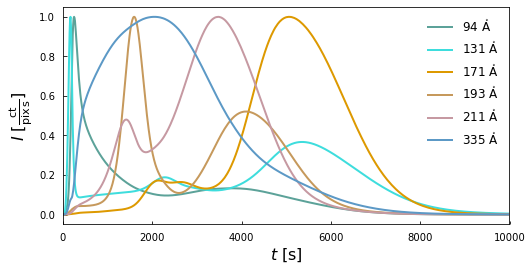

In [78]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
for c in aia.channels:
    color = sunpy.cm.cmlist['sdoaia{}'.format(c['name'])](0.6)
    ts = map_cubes_cooling[c['name']][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
    ts /= ts.max()
    ts = ts*u.count/u.s/u.pixel
    ax.plot(aia.observing_time,ts,label=r'{} $\mathrm{{\mathring{{A}}}}$'.format(c['name']),color=color)
ax.legend(loc='best',frameon=False)
ax.set_xlim([0,aia.observing_time[-1].value])
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$I$ [{:latex}]'.format(ts.unit))
ax.tick_params(axis='both',direction='in',which='both')
fig.savefig('../figures/cooling_timeseries_1d.pdf')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


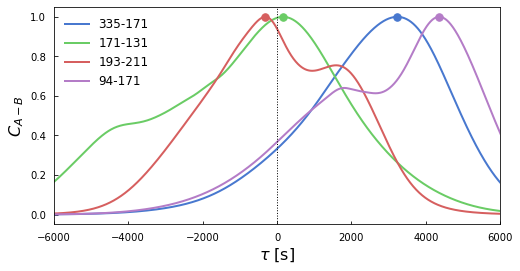

In [79]:
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
colors = sns.color_palette('muted')
for i,p in enumerate([('335','171'),('171','131'),('193','211'),('94','171')]):
    ts_a = map_cubes_cooling[p[0]][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
    ts_a /= ts_a.max()
    ts_b = map_cubes_cooling[p[1]][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
    ts_b /= ts_b.max()
    cc = np.fft.irfft(np.fft.rfft(ts_a[::-1],n=timelags.shape[0])*np.fft.rfft(ts_b,n=timelags.shape[0]),
                      n=timelags.shape[0])
    ax.plot(timelags,cc/cc.max(),label=r'{}-{}'.format(*p),color=colors[i])
    ax.plot(timelags[np.argmax(cc)],1,'o',color=colors[i],markersize=7.5)
ax.set_xlim([-6000,6000])
ax.legend(loc='best',frameon=False)
ax.axvline(x=0,ls=':',lw=1,color='k')
ax.set_xlabel(r'$\tau$ [s]')
ax.set_ylabel(r'$C_{A-B}$')
ax.tick_params(axis='both',direction='in',which='both')
fig.savefig('../figures/cooling_cross_correlations_1d.pdf')

## Maps
Make maps for the 335-171 pair for the four heating scenarios.

In [45]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:43548 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 162.23 GB


In [46]:
def make_timelag_map(cubes,channel_a,channel_b,map_meta):
    chan_a_cube = cubes[channel_a]/np.where(cubes[channel_a].max(axis=2)==0,1.,
                                            cubes[channel_a].max(axis=2))[:,:,np.newaxis]
    chan_b_cube = cubes[channel_b]/np.where(cubes[channel_b].max(axis=2)==0,1.,
                                            cubes[channel_b].max(axis=2))[:,:,np.newaxis]
    fft_a = dask.array.fft.rfft(dask.array.from_array(chan_a_cube[:,:,::-1],chunks=(20,20)+aia.observing_time.shape),
                                axis=2,n=timelags.shape[0])
    fft_b = dask.array.fft.rfft(dask.array.from_array(chan_b_cube,chunks=(20,20)+aia.observing_time.shape),
                                axis=2,n=timelags.shape[0])
    cc_ab = dask.array.fft.irfft(fft_a*fft_b,axis=2,n=timelags.shape[0]).compute()
    
    max_correlation = np.max(cc_ab,axis=2)
    max_timelag = timelags[np.argmax(cc_ab,axis=2)]
    
    timelag_map = GenericMap(np.where(max_correlation<1.,0,max_timelag),map_meta.copy())
    correlation_map = GenericMap(max_correlation,map_meta.copy())
    
    return timelag_map,correlation_map

In [47]:
lags335_171_cooling,correlations335_171_cooling = make_timelag_map(map_cubes_cooling,'335','171',tmp.meta)

In [48]:
lags335_171_hf,correlations335_171_hf = make_timelag_map(map_cubes_hf,'335','171',tmp.meta)

In [49]:
lags335_171_if,correlations335_171_if = make_timelag_map(map_cubes_if,'335','171',tmp.meta)

In [50]:
lags335_171_lf,correlations335_171_lf = make_timelag_map(map_cubes_lf,'335','171',tmp.meta)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


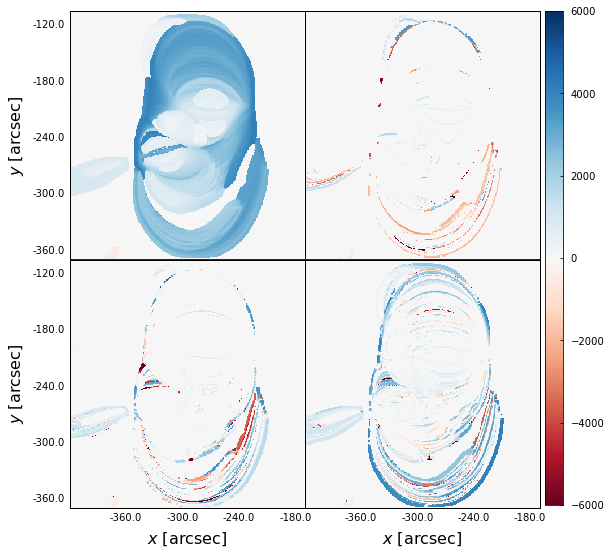

In [73]:
fig = plt.figure(figsize=(8,9.15))
options = {'annotate':False,'title':False,'vmin':-6000,'vmax':6000,'cmap':'RdBu'}
plt.subplots_adjust(right=0.94,hspace=0,wspace=0)
cax = fig.add_axes([0.95,0.13,0.03,0.75])
# cooling
ax = fig.add_subplot(221,projection=lags335_171_cooling)
lags335_171_cooling.plot(axes=ax,**options)
ax.coords[0].set_ticks_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[1].set_axislabel(r'$y$ [arcsec]',size=plt.rcParams['axes.labelsize'])
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
# high-frequency
ax = fig.add_subplot(222,projection=lags335_171_hf)
lags335_171_hf.plot(axes=ax,**options)
ax.coords[0].set_ticks_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticks_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
# intermediate-frequency
ax = fig.add_subplot(223,projection=lags335_171_if)
lags335_171_if.plot(axes=ax,**options)
ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[0].set_axislabel(r'$x$ [arcsec]',size=plt.rcParams['axes.labelsize'])
ax.coords[1].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[1].set_axislabel(r'$y$ [arcsec]',size=plt.rcParams['axes.labelsize'])
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
# low-frequency
ax = fig.add_subplot(224,projection=lags335_171_lf)
im = lags335_171_lf.plot(axes=ax,**options)
ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[0].set_axislabel(r'$x$ [arcsec]',size=plt.rcParams['axes.labelsize'])
ax.coords[1].set_ticks_visible(False)
ax.coords[1].set_ticklabel_visible(False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
# colorbar
cbar = fig.colorbar(im,cax=cax)
cbar.ax.tick_params(axis='y',direction='in')
fig.savefig('../figures/timelag_maps_335_171.pdf')

## Histograms
Compute the 94-171 maps so that we can make the histograms for those as well

In [74]:
lags94_171_cooling,correlations94_171_cooling = make_timelag_map(map_cubes_cooling,'94','171',tmp.meta)

In [75]:
lags94_171_hf,correlations94_171_hf = make_timelag_map(map_cubes_hf,'94','171',tmp.meta)

In [76]:
lags94_171_if,correlations94_171_if = make_timelag_map(map_cubes_if,'94','171',tmp.meta)

In [80]:
lags94_171_lf,correlations94_171_lf = make_timelag_map(map_cubes_lf,'94','171',tmp.meta)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


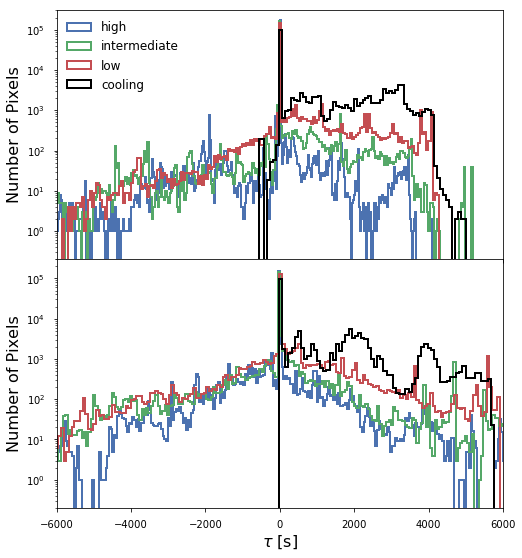

In [129]:
fig,axes = plt.subplots(2,1,figsize=(8,9.15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.)
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False}
#335-171
axes[0].hist(lags335_171_hf.data.flatten(),**params,label='high',color=sns.color_palette()[0])
axes[0].hist(lags335_171_if.data.flatten(),**params,label='intermediate',color=sns.color_palette()[1])
axes[0].hist(lags335_171_lf.data.flatten(),**params,label='low',color=sns.color_palette()[2])
axes[0].hist(lags335_171_cooling.data.flatten(),**params,label='cooling',color='k')
#94-171
axes[1].hist(lags94_171_hf.data.flatten(),**params,label='high',color=sns.color_palette()[0])
axes[1].hist(lags94_171_if.data.flatten(),**params,label='intermediate',color=sns.color_palette()[1])
axes[1].hist(lags94_171_lf.data.flatten(),**params,label='low',color=sns.color_palette()[2])
axes[1].hist(lags94_171_cooling.data.flatten(),**params,label='cooling',color='k')
axes[0].legend(loc='best',frameon=False)
axes[0].set_xlim([-6000,6000])
axes[1].set_ylim([0.2,3e5])
axes[1].set_xlabel(r'$\tau$ [s]')
axes[0].set_ylabel(r'Number of Pixels')
axes[1].set_ylabel(r'Number of Pixels')
fig.savefig('../figures/timelag_histograms.pdf')

## DAG Visualization
Create a mini version of the timelag calculation (on a 2-by-2 array) so that we can include a DAG diagram.

In [99]:
ts_a = np.random.rand(2,2,100)
ts_b = np.random.rand(2,2,100)

In [120]:
foo = dask.array.fft.irfft(
    dask.array.fft.rfft(dask.array.from_array(ts_a,chunks=(1,1,100)),axis=2)
    *dask.array.fft.rfft(dask.array.from_array(ts_b,chunks=(1,1,100)),axis=2),
    axis=2
)

In [122]:
foo.visualize(
    filename='../figures/timelag_dag.pdf',
    format='pdf',
    optimize_graph=True
)